In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 1000)

/home/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [2]:
# links
# https://drive.google.com/drive/folders/18dV790r11hHKIwpbyDBaxMV4XbhBFQde?usp=drive_link

In [4]:
n = pypsa.Network()

In [5]:
# entsoe network file
entsoe_nc = pypsa.Network("elec-entsoe.nc")

INFO:pypsa.io:Imported network elec-entsoe.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


In [6]:
# load entsoe line.csv with pandas dataframe
entsoe_ref_csv = pd.read_csv("entsoe_lines_ref.csv", delimiter=",", quotechar="'")

# apply well known text(wkt) to format the geometry column properly
entsoe_ref_csv["geometry"] = entsoe_ref_csv.geometry.apply(wkt.loads)

# load the data into a geopandas dataframe and format it using a compatible crs
entsoe_csv = gpd.GeoDataFrame(entsoe_ref_csv, geometry="geometry", crs="EPSG:3035")

# convert voltage from kV to V
entsoe_csv["voltage"] = entsoe_csv.voltage * 1000

In [7]:
# networks
de_base_nc_file = f"osm_data_validation_AT_MK_IT_DE/networks/DE/base.nc"
it_base_nc_file = f"osm_data_validation_AT_MK_IT_DE/networks/IT/base.nc"

# resource files
de_base_csv_file = f"osm_data_validation_AT_MK_IT_DE/resources/DE/base_network/all_lines_build_network.csv"
it_base_csv_file = f"osm_data_validation_AT_MK_IT_DE/resources/IT/base_network/all_lines_build_network.csv"

de_country_shape_file = f"osm_data_validation_AT_MK_IT_DE/resources/DE/shapes/country_shapes.geojson"
it_country_shape_file = f"osm_data_validation_AT_MK_IT_DE/resources/IT/shapes/country_shapes.geojson"

In [8]:
# loading network files with pypsa
de_base_nc = pypsa.Network(de_base_nc_file)
it_base_nc = pypsa.Network(it_base_nc_file)

# loading base csv file with pandas, then load it into geopandas dataframe
de_base_csv = pd.read_csv(de_base_csv_file)
de_base_csv["geometry"] = de_base_csv.geometry.apply(wkt.loads)
de_base_csv = gpd.GeoDataFrame(de_base_csv, geometry="geometry", crs="EPSG:4326")
de_base_csv["converted_length"] = de_base_csv.to_crs("EPSG:3035").length

it_base_csv = pd.read_csv(it_base_csv_file)
it_base_csv["geometry"] = it_base_csv.geometry.apply(wkt.loads)
it_base_csv = gpd.GeoDataFrame(it_base_csv, geometry="geometry", crs="EPSG:4326")
it_base_csv["converted_length"] = it_base_csv.to_crs("EPSG:3035").length

INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers
INFO:pypsa.io:Imported network base.nc has buses, lines, links, transformers


In [9]:
de_country_shape = gpd.read_file(de_country_shape_file)
it_country_shape = gpd.read_file(it_country_shape_file)

In [10]:
def get_i_nom_by_voltage(voltage_value: int, voltage_dict: dict, network: pypsa.Network) -> int:
    """
    func returns the current corresponding to the voltage_value using line_types in pypsa network
    """

    line_type = max(voltage_dict.values())

    for idx in sorted(voltage_dict.keys()):
        if (voltage_value) <= idx:
            line_type = voltage_dict.get(idx)
            break
        
    return network.line_types.loc[line_type, "i_nom"] # kA


def calculate_s_nom(df: gpd.GeoDataFrame, voltage_dict: dict, network: pypsa.Network) -> gpd.GeoDataFrame:
    """
    Func calc s_nom using the s_nom defined formula from pypsa earth
    s_nom = sqrt(3) * v_nom(kV) * circuits * i_nom(kA)
    """    
    
    df['voltage_kV'] = df['voltage'] / 1e3 # divide voltage by 1e3 to convert it to kV
    df["s_nom"] = (df["voltage"].apply(lambda row: get_i_nom_by_voltage(row, voltage_dict, n))) \
                    * df["voltage_kV"] \
                    * np.sqrt(3) * df["circuits"]

    # s_nom units in MVA

    return df
    

In [11]:
# dictionary storing standard line types used in pypsa-earth workflow
voltage_dict = {
        220: "Al/St 240/40 2-bundle 220.0",
        300: "Al/St 240/40 3-bundle 300.0",
        380: "Al/St 240/40 4-bundle 380.0",
    }

In [12]:
# Calculate 's_nom' values
de_base_csv_s_nom = calculate_s_nom(de_base_csv, voltage_dict, network=n)
it_base_csv_s_nom = calculate_s_nom(it_base_csv, voltage_dict, network=n)

In [13]:
# get the sum total for s_nom in base_csv and base_nc
sum_de_base_csv_snom = de_base_csv_s_nom.s_nom.sum()
sum_de_base_nc_snom = de_base_nc.lines.s_nom.sum()

sum_it_base_csv_snom = it_base_csv_s_nom.s_nom.sum()
sum_it_base_nc_snom = it_base_nc.lines.s_nom.sum()

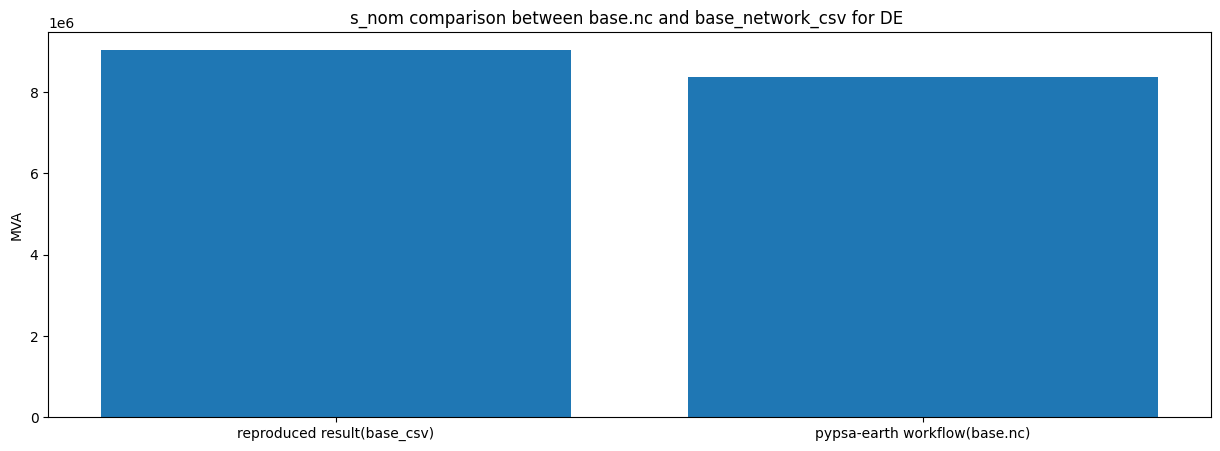

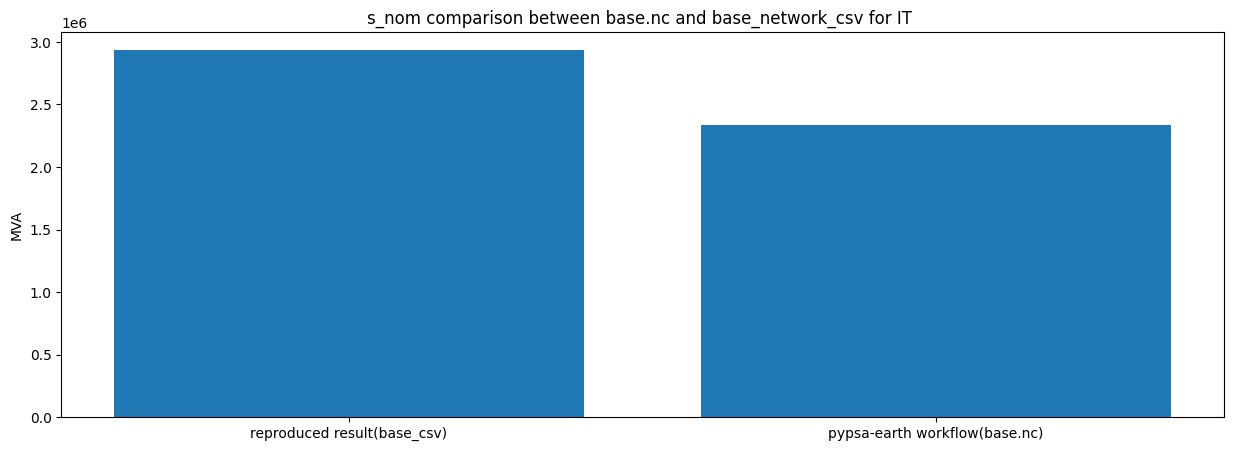

In [14]:
# plots comparison for reproduced workflow vs pypsa-earth workflow

plt.figure(figsize=(15,5))
plt.bar(["reproduced result(base_csv)", "pypsa-earth workflow(base.nc)"], 
        [sum_de_base_csv_snom, sum_de_base_nc_snom])
plt.title(f"s_nom comparison between base.nc and base_network_csv for DE ")
plt.ylabel("MVA")

plt.figure(figsize=(15,5))
plt.bar(["reproduced result(base_csv)", "pypsa-earth workflow(base.nc)"], 
        [sum_it_base_csv_snom, sum_it_base_nc_snom])
plt.title(f"s_nom comparison between base.nc and base_network_csv for IT ")
plt.ylabel("MVA")
plt.show()

In [15]:
entsoe_nc.lines.v_nom.value_counts()

220    3408
380    2887
300     397
Name: v_nom, dtype: int64

In [16]:
entsoe_csv.voltage.value_counts()

220000    5812
380000    3595
300000     831
132000     633
500000     234
750000      46
Name: voltage, dtype: int64

In [17]:
# create a new column to easily identify DE and IT in entsoe_csv
entsoe_csv[f"if_de"] = entsoe_csv["geometry"].apply(lambda row: row.within(de_country_shape["geometry"][0]))
entsoe_csv[f"if_it"] = entsoe_csv["geometry"].apply(lambda row: row.within(it_country_shape["geometry"][0]))

In [18]:
# merge country data in bus into entsoe_nc lines
entsoe_nc_country = entsoe_nc.lines \
        .merge(entsoe_nc.buses['country'] \
        .reset_index(), 
            how='left', 
            left_on='bus0', 
            right_on='Bus')

In [19]:
# filtering for country data in entsoe_nc
entsoe_nc_filtered_de = entsoe_nc_country[entsoe_nc_country.country == "DE"]
entsoe_nc_filtered_it = entsoe_nc_country[entsoe_nc_country.country == "IT"]


In [20]:
# set voltage_threshold
voltage_threshold = 200000

In [22]:
# get sum total for s_nom for records above the set threshold

sum_de_base_csv_snom_200kv = de_base_csv_s_nom[de_base_csv_s_nom.voltage > voltage_threshold].s_nom.sum()
sum_it_base_csv_snom_200kv = it_base_csv_s_nom[it_base_csv_s_nom.voltage > voltage_threshold].s_nom.sum()

entsoe_s_nom = calculate_s_nom(entsoe_csv[entsoe_csv.voltage >= voltage_threshold], voltage_dict, n)
sum_de_entsoe_snom = entsoe_s_nom[entsoe_s_nom[f"if_de"] == True].s_nom.sum()
sum_it_entsoe_snom = entsoe_s_nom[entsoe_s_nom[f"if_it"] == True].s_nom.sum()

sum_entose_nc_de_snom = entsoe_nc_filtered_de.s_nom.sum()
sum_entose_nc_it_snom = entsoe_nc_filtered_it.s_nom.sum()


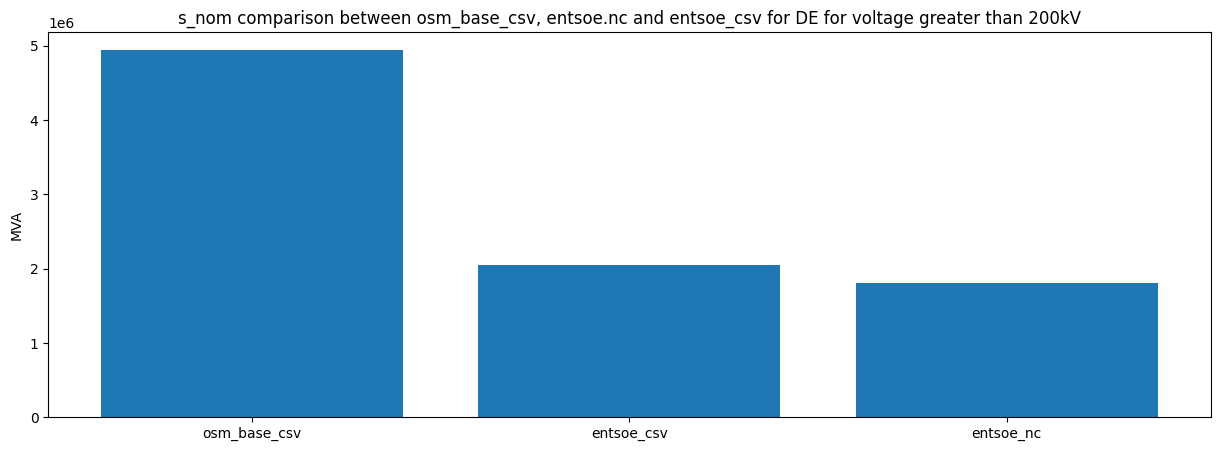

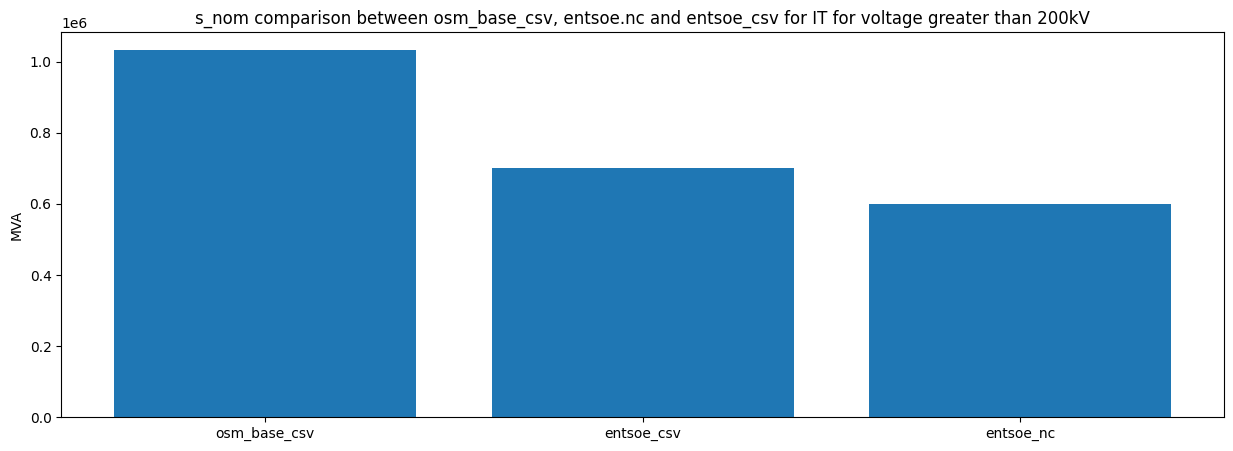

In [23]:
# plots comparison for s_nom between osm_base_network_csv, entsoe_csv and entsoe_nc

plt.figure(figsize=(15,5))
plt.bar(["osm_base_csv", "entsoe_csv", "entsoe_nc"], 
        [sum_de_base_csv_snom_200kv, sum_de_entsoe_snom, sum_entose_nc_de_snom])
plt.title(f"s_nom comparison between osm_base_csv, entsoe.nc and entsoe_csv for DE for voltage greater than 200kV")
plt.ylabel("MVA")

plt.figure(figsize=(15,5))
plt.bar(["osm_base_csv", "entsoe_csv", "entsoe_nc"], 
        [sum_it_base_csv_snom_200kv, sum_it_entsoe_snom, sum_entose_nc_it_snom])
plt.title(f"s_nom comparison between osm_base_csv, entsoe.nc and entsoe_csv for IT for voltage greater than 200kV")
plt.ylabel("MVA")
plt.show()

In [24]:
# total sum of line capacity in base_csv for lines above the set threshold
de_base_csv_s_nom_220kv = de_base_csv_s_nom[de_base_csv_s_nom.voltage > voltage_threshold]
de_twkm_base_csv = (de_base_csv_s_nom_220kv.s_nom * 
                    de_base_csv_s_nom_220kv.converted_length).sum() / 1e3

it_base_csv_s_nom_220kv = it_base_csv_s_nom[it_base_csv_s_nom.voltage > voltage_threshold]
it_twkm_base_csv = (it_base_csv_s_nom_220kv.s_nom * 
                    it_base_csv_s_nom_220kv.converted_length).sum() / 1e3

In [25]:
# total sum of line capacity in entsoe_csv
de_entsoe_snom_csv = entsoe_s_nom[entsoe_s_nom[f"if_de"] == True]
de_twkm_entsoe_csv = ((de_entsoe_snom_csv["length"] / 1e3) 
                        * (de_entsoe_snom_csv["s_nom"])).sum()

it_entsoe_snom_csv = entsoe_s_nom[entsoe_s_nom[f"if_it"] == True]
it_twkm_entsoe_csv = ((it_entsoe_snom_csv["length"] / 1e3) 
                        * (it_entsoe_snom_csv["s_nom"])).sum()

In [26]:
# total sum of line capacity in entsoe_nc
de_twkm_entsoe_nc = (entsoe_nc_filtered_de["length"] 
                    * entsoe_nc_filtered_de["s_nom"]).sum()

it_twkm_entsoe_nc = (entsoe_nc_filtered_it["length"] 
                    * entsoe_nc_filtered_it["s_nom"]).sum()

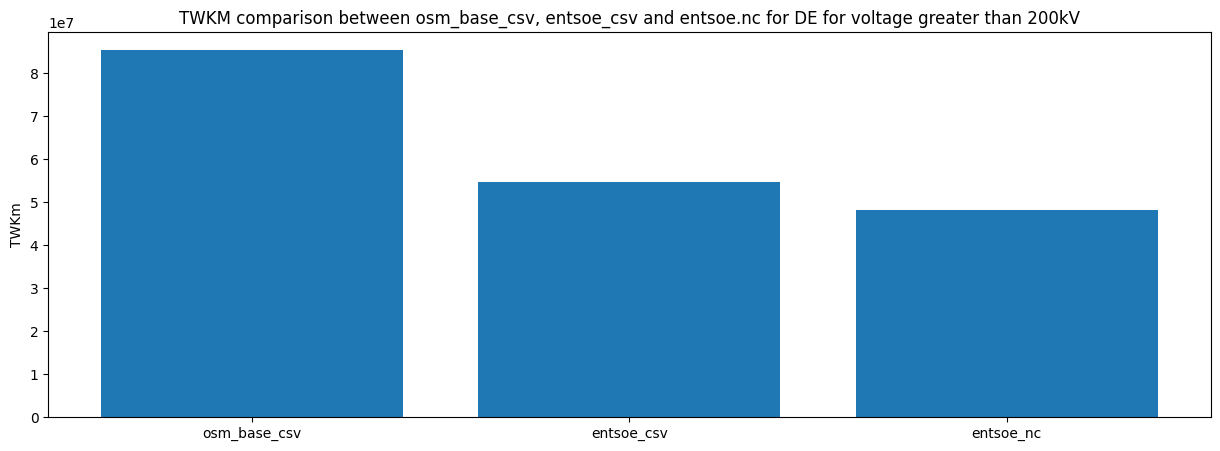

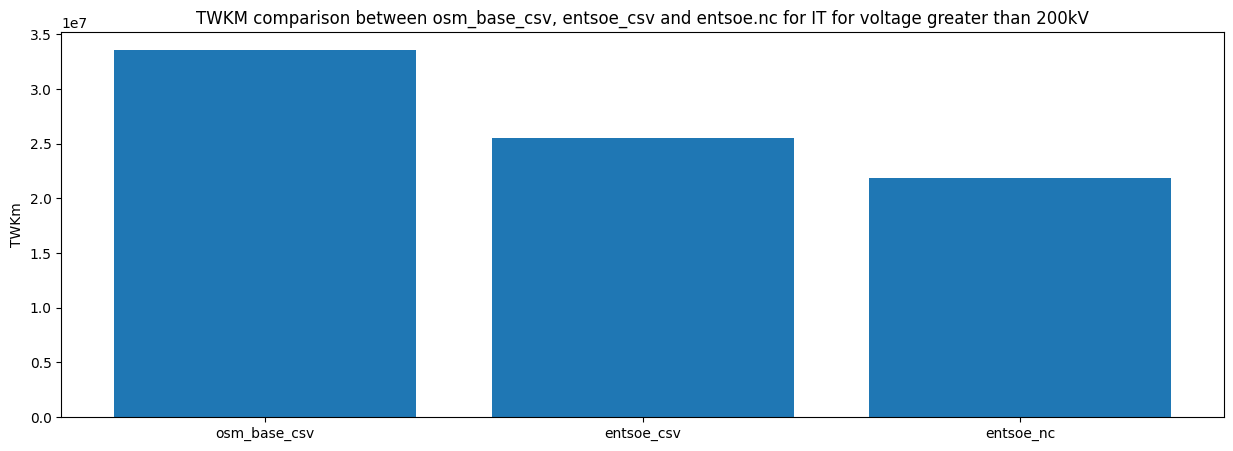

In [27]:
# plot comparison for line capacity between osm_base_csv, entsoe_csv and entsoe_nc

plt.figure(figsize=(15,5))
plt.bar(["osm_base_csv", "entsoe_csv", "entsoe_nc"], 
        [de_twkm_base_csv, de_twkm_entsoe_csv, de_twkm_entsoe_nc])
plt.title(f"TWKM comparison between osm_base_csv, entsoe_csv and entsoe.nc for DE for voltage greater than 200kV")
plt.ylabel("TWKm")

plt.figure(figsize=(15,5))
plt.bar(["osm_base_csv", "entsoe_csv", "entsoe_nc"], 
        [it_twkm_base_csv, it_twkm_entsoe_csv, it_twkm_entsoe_nc])
plt.title(f"TWKM comparison between osm_base_csv, entsoe_csv and entsoe.nc for IT for voltage greater than 200kV")
plt.ylabel("TWKm")
plt.show()

### Auxiliary s_nom

In [28]:
# removing the effect from num_parallel/circuits from s_nom
entsoe_nc_filtered_de["s_nom_aux"] = entsoe_nc_filtered_de["s_nom"] / entsoe_nc_filtered_de["num_parallel"]
entsoe_nc_filtered_it["s_nom_aux"] = entsoe_nc_filtered_it["s_nom"] / entsoe_nc_filtered_it["num_parallel"]

In [29]:
# removing the effect from num_parallel/circuits from s_nom
de_base_csv_s_nom["s_nom_aux"] = de_base_csv_s_nom['s_nom'] / de_base_csv_s_nom['circuits']
it_base_csv_s_nom["s_nom_aux"] = it_base_csv_s_nom['s_nom'] / it_base_csv_s_nom['circuits']

In [30]:
# removing the effect from num_parallel/circuits from s_nom
entsoe_s_nom["s_nom_aux"] = entsoe_s_nom.apply(lambda row: row['s_nom'] / row['circuits'], axis=1)

In [31]:
# table comparing auxiliary s_nom with s_nom in base_csv for DE
de_base_csv_s_nom.groupby(["voltage"]).mean()[['s_nom_aux']] \
    .merge(de_base_csv_s_nom.groupby(["voltage"]).mean()[['s_nom']], 
            left_on="voltage", right_on="voltage")

,s_nom_aux,s_nom
voltage,,
60000,268.121465,329.995649
63000,281.527538,656.897589
65000,290.464920,668.069317
110000,491.556019,1084.063977
150000,670.303663,670.303663
155000,692.647118,692.647118
220000,983.112038,3091.328058
225000,1005.455494,3016.366481
300000,1340.607325,1340.607325


In [32]:
# table comparing auxiliary s_nom with s_nom in entsoe_csv for DE
entsoe_s_nom[entsoe_s_nom[f"if_de"] == True] \
    .groupby(["voltage"]).mean()[["s_nom_aux"]] \
    .merge(entsoe_s_nom[entsoe_s_nom[f"if_de"] == True]
            .groupby(["voltage"])
            .mean()[["s_nom"]], 
                left_on="voltage", right_on="voltage")

,s_nom_aux,s_nom
voltage,,
220000,983.112038,1907.129911
380000,1698.102612,3667.608233


In [33]:
# table comparing auxiliary s_nom with s_nom in base_csv for IT
it_base_csv_s_nom.groupby(["voltage"]).mean()[['s_nom_aux']] \
    .merge(it_base_csv_s_nom.groupby(["voltage"]).mean()[['s_nom']], 
            left_on="voltage", right_on="voltage")

,s_nom_aux,s_nom
voltage,,
60000,268.121465,287.671989
66000,294.933612,294.933612
70000,312.808376,312.808376
110000,491.556019,491.556019
120000,536.242930,643.491516
130000,580.929841,580.929841
132000,589.867223,660.224880
135000,603.273296,603.273296
150000,670.303663,727.832135


In [34]:
# table comparing auxiliary s_nom with s_nom in entsoe_csv for IT
entsoe_s_nom[entsoe_s_nom[f"if_it"] == True] \
    .groupby(["voltage"]).mean()[["s_nom_aux"]] \
    .merge(entsoe_s_nom[entsoe_s_nom[f"if_it"] == True]
            .groupby(["voltage"])
            .mean()[["s_nom"]], 
                left_on="voltage", right_on="voltage")

,s_nom_aux,s_nom
voltage,,
220000,983.112038,1228.890048
380000,1698.102612,1928.709139
